# Implement MNIST Classifier using Autograd

### Download the MNIST dataset

In [1]:
# Import the necessary libraries 
import sys, numpy as np
from keras.datasets import mnist
%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(0)

Using TensorFlow backend.


In [2]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


The dataset has a training set of `60,000` examples and test set of `10,000` examples.

In [3]:
print("Training examples: ",x_train.shape)
print("Test examples: ",x_test.shape)

Training examples:  (60000, 28, 28)
Test examples:  (10000, 28, 28)


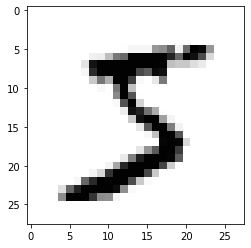

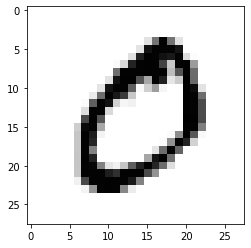

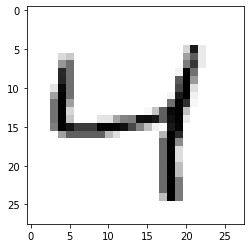

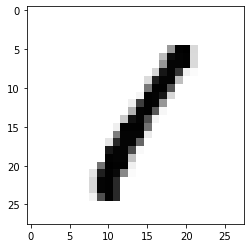

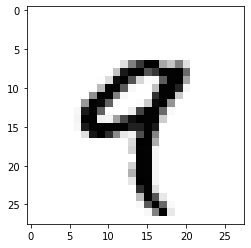

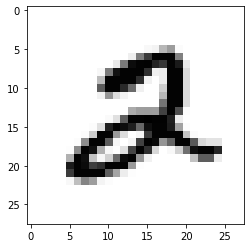

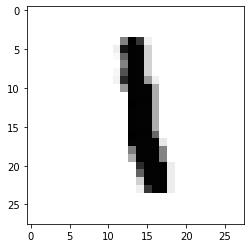

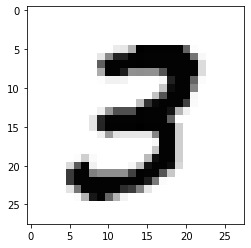

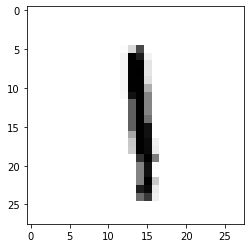

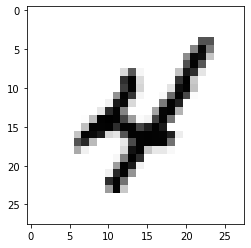

In [4]:
# Before preprocessing the dataset with neural network, checking the data
for i in range(10):
    img = np.asfarray(x_train)[i].reshape((28,28))
    plt.imshow(img, cmap="Greys")
    plt.show()

In [0]:
type(images)

numpy.ndarray

### Define the network Architecture 

In [0]:
class Tensor:
    '''The tensor data should be in np array'''
    '''grad will hold hold the gradient from backward prop'''
    def __init__(self, data, requires_grad=False):
        self.data = data
        if not isinstance(data, np.ndarray):
            self.data = np.array(data)
        # This is check whether to run backpropagation or not
        self.requires_grad = requires_grad
        # Tensor gradient
        self._grad = None
        # Operation if tensor was used
        self._grad_fn = None

    @property
    def shape(self):
        return self.data.shape

    @property
    def grad_fn(self):
        if not self.requires_grad:
            raise Exception('Tensor not backpropagated')
        return self._grad_fn

    @property
    def grad(self):
        return self._grad

    def backward(self, grad=None):
        if not self.grad_fn:
            return False

        if grad is None and self._grad is None:
            # in case if this is last loss tensor
            grad = self.__class__(1., requires_grad=False)

        elif self.grad is not None:
            grad = self._grad

        if not self.requires_grad:
            raise Exception('Tensor not backpropagated')

        self.grad_fn.backward(grad)
        return True

    '''Return the Tensor value'''
    def __str__(self):
        return f'Tensor({str(self.data)})'

    '''add the gradients'''
    def add_grad(self, grad):
        if self._grad is None:
            self._grad = grad
        else:
            self._grad += grad
    '''add the tensor object with other'''
    def __add__(self, o): 
        if self.data is not None:
            self.data += o.data  
            return self
        self.data = o.data 
        return self

In [0]:
class Operations:
    '''Operations that neural-network will perform'''
    '''Tensor object adds two new features'''
    def forward(self):
        raise NotImplemented

    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        self.out = self.forward(*args)
        self.out._grad_fn = self
        return self.out

In [0]:
class AddOp(Operations):
    '''AddOp will extend from Op'''
    '''Sumation operation with 2 tensors'''

    def forward(self, x: Tensor, y: Tensor):
        self.x = x
        self.y = y
        # created tensor should be backpropagated if at least one 
        # of the input is backpropagated
        requires_grad = x.requires_grad or y.requires_grad
        return Tensor(x.data + y.data, requires_grad=requires_grad)

    def backward(self, grad):
        if self.x.requires_grad:
            # as we have matrix operation one of the parameters can 
            # have partial shape in such scenarion we need to sum
            # gradient values by missed axis
            if self.x.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.x.shape) - 
                                 np.array(grad.shape)))
                self.x.add_grad(Tensor(grad.data.sum(axis=axis, 
                                                keepdims=True)))
            else:
                self.x.add_grad(grad)
            if self.x.grad_fn:
                self.x.backward()
        if self.y.requires_grad:
            if self.y.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.y.shape) - 
                                        np.array(grad.shape)))
                self.y.add_grad(Tensor(grad.data.sum(axis=axis, 
                                                keepdims=True)))
            else:
                self.y.add_grad(grad)
            if self.y.grad_fn:
                self.y.backward()

In [0]:
class MulOp(Operations):
    '''MulOp will extend from Op'''
    '''Multiplication operation with 2 tensors'''

    def forward(self, x: Tensor, y: Tensor):
        self.x = x
        self.y = y
        requires_grad = x.requires_grad or y.requires_grad
        return Tensor(x.data * y.data, requires_grad=requires_grad)

    def backward(self, grad):
        if self.x.requires_grad:
            print(self.x, self.x._grad, grad)
            self.x.add_grad(Tensor(grad.data * self.y.data, False))
            if self.x.grad_fn:
                self.x.backward()
        if self.y.requires_grad:
            self.y.add_grad(Tensor(grad.data * self.x.data, False))
            if self.y.grad_fn:
                self.y.backward()

In [0]:
class Layer:
    '''Define the layer class'''
    def forward(self):
        raise NotImplemented

    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        return self.forward(*args)

In [0]:
class Sigmoid:
    '''Sigmoid Activation Function Implementation'''
    def forward(self,x):
        self.x = x   
        return 1/(1+np.exp(-x))

    def backward(self, grad):
        grad_input = self.x*(1-self.x) * grad
        return grad_input

In [0]:
class Relu(Layer):
    '''Relu Activation Function Implementation'''
    def forward(self,x):
        self.x = x
        return np.maximum(np.zeros_like(x), x)

    def backward(self, grad):
        grad_input = (self.x > 0) * grad
        return grad_input

In [0]:
class SoftmaxCrossentropyWithLogits(Layer):
    '''Softmax Activation Function Implementation'''
    def forward(self, x, y):
        self.x = x
        self.y = y

        exps = np.exp(x) 
        self.softmax = exps / np.sum(exps, axis=-1, keepdims=True)

        logits = self.softmax[np.arange(x.shape[0]),y]
        log_likelihood = -np.log(logits)
        loss = np.sum(log_likelihood) / x.shape[0]
        return loss

    def backward(self, grad=None):
        batch = self.x.shape[0]
        grad = self.softmax
        grad[np.arange(batch),self.y] -= 1
        grad = grad/batch
        return grad

In [0]:
class MSE(Layer):
    '''Mean Square Error Implementation'''
    def forward(self, x, y):
        self.x = x
        self.y = y
        return ((x - y)**2) / (self.x.shape[0]*2)

    def backward(self, grad=None):
        # 1/2n * Sum(xi-yi)**2 
        # dx = 1/2n * Sum( x**2 -2*x*y + y**2) 
        # dx  = (2x - 2y) / 2*n = (x - y) / n
        return (self.x - self.y) / self.x.shape[0]

In [0]:
class Linear(Layer):

    def __init__(self, input, output, lr=0.0001):
        '''Initialize the weigths'''
        self.A = 2*np.random.random((input, output)) - 1
        self.b = 2*np.random.random((output)) - 1
        self.lr = lr

    def forward(self, x):
        '''Multiply the weights with the inputs and add bias'''
        self.x = x
        return np.dot(x,self.A) + self.b
        
    '''Backpropagation'''
    def backward(self, grad):
        # d_layer / db = 1
        b_grad = grad.mean(axis=0)*self.x.shape[0]
        # d_layer / dA = x
        A_grad = np.dot(self.x.T, grad)
        # As this layer have somee weights we need to update them using 
        # gradient descent
        # compute df / dx = df / d_layer * d_layer / dx
        # df / d_layer == grad
        grad_input = np.dot(grad, self.A.T)

        self.A -= A_grad * self.lr
        self.b -= b_grad * self.lr

        return grad_input

In [0]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

In [0]:
class Model(Layer):
    '''The Model consists of Linear Sequential Layer with 784 neurons in the input layer'''
    '''Input(784) => Relu => Hidden(100) => Relu => Hidden(200) => Output(10) '''
    def __init__(self, lr=0.00001):
        self.lr = lr
        '''Defining the layers'''
        self.layers = [
            Linear(784,100, lr=self.lr),
            Relu(),
            Linear(100,200, lr=self.lr),
            Relu(),
            Linear(200,10, lr=self.lr)        
        ]

    def forward(self,x):
        for l in self.layers:
            x = l(x)
        return x

    def backward(self, grad):
        for l in self.layers[::-1]:
            grad = l.backward(grad)

        return grad

In [0]:
# converts to [0,1] interval
transform = transforms.Compose([transforms.ToTensor(),])

In [58]:
transform

Compose(
    ToTensor()
)

In [0]:
ds = MNIST('./mnist', download=True, transform=transform)

In [0]:
dl = DataLoader(ds, batch_size=2, pin_memory=True, drop_last=True) 

In [61]:
dl

In [0]:
mn = Model()
loss = SoftmaxCrossentropyWithLogits()
_loss_avg = 0

In [63]:
for e in range(5):
    for i, (img, label) in enumerate(dl):
        x = img.view(2,-1).numpy()

        res = mn(x)
        _loss = loss(res, label.numpy())
        _loss_avg += _loss.mean() # loss mean is calculated
        grad = loss.backward(1)
        mn.backward(grad)

        if i % 100 == 0:
            print(_loss_avg/100)
            _loss_avg = 0
            print('---------')

1.5188815921276602
---------
167.62858175071545
---------
139.26943105069964
---------
140.49006346101282
---------
139.2657837231371
---------
149.5607838210521
---------
122.42704986187474
---------
154.57436141106626
---------
123.60510404627374
---------
131.50013873844523
---------
115.38097951876857
---------
114.3105978122988
---------
104.8709365576994
---------
101.12072922718674
---------
106.16556371387243
---------
101.64395695056619
---------
97.88865323207413
---------
85.7702338013474
---------
85.19314075484277
---------
106.53161917397945
---------
87.81728923738532
---------
89.06939834888935
---------
92.66308635466558
---------
83.03737094346019
---------
86.8589488975331
---------
103.30255242454164
---------
85.00308429512059
---------
82.19148652767639
---------
85.05058257317506
---------
80.22533437368125
---------
78.1555507769594
---------
78.70078362843215
---------
82.85051306628704
---------
65.62337933370685
---------
73.69789647410673
---------
74.596633

Evaluate the Network

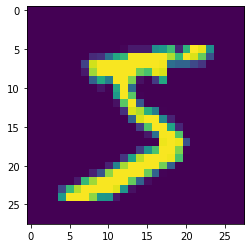

target: 5 predicted: 2


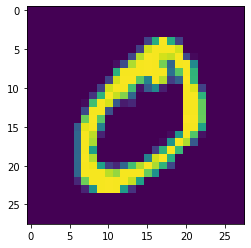

target: 0 predicted: 0


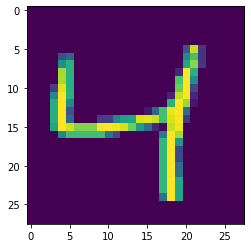

target: 4 predicted: 4


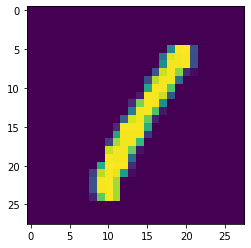

target: 1 predicted: 1


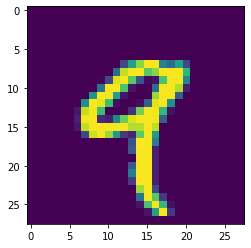

target: 9 predicted: 9


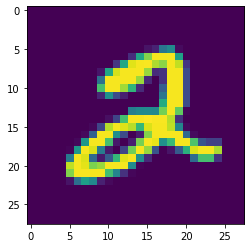

target: 2 predicted: 2


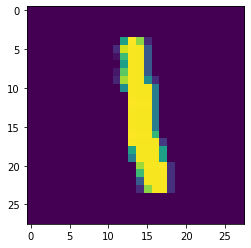

target: 1 predicted: 1


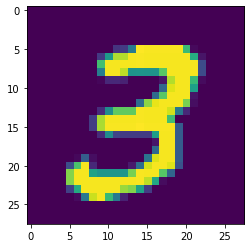

target: 3 predicted: 3


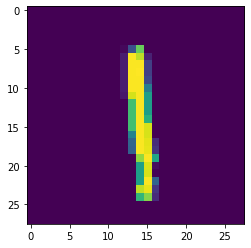

target: 1 predicted: 1


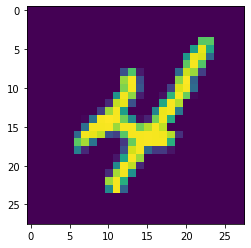

target: 4 predicted: 4


In [64]:
for i in range(10):
    img, target = ds[i]
    plt.imshow(img[0])
    plt.show()
    x = img.view(1,-1).numpy()
    res = mm(x)[0]
    pred = np.argmax(res)
    print(f'target: {target} predicted: {pred}' )